In [25]:
import os
import re
import numpy as np
import numpy.random as random
import pandas as pd
from PIL import Image
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
os.environ["TOKENIZERS_PARALLELISM"] = "false"
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torch.utils.data import Subset
from torch.autograd import Variable
import wandb
from scipy.linalg import sqrtm
from torchvision.models import inception_v3
from torchvision.datasets import ImageFolder
from PIL import Image

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
pip install torch-fidelity

In [ ]:
pip install torchmetrics[image]

In [ ]:
pip install torchmetrics

In [ ]:
!pip install sentence-transformers

In [27]:
# Data paths
train_annotations = '/kaggle/input/coco-2017-dataset/coco2017/annotations/captions_train2017.json'
train_images_dir = '/kaggle/input/coco-2017-dataset/coco2017/train2017'
val_annotations = '/kaggle/input/coco-2017-dataset/coco2017/annotations/captions_val2017.json'
val_images_dir = '/kaggle/input/coco-2017-dataset/coco2017/val2017'
test_images_dir = '/kaggle/input/coco-2017-dataset/coco2017/test2017'

Image ID: 000000270066
Number of captions: 5
Image URL: /kaggle/input/coco-2017-dataset/coco2017/val2017/000000270066.jpg


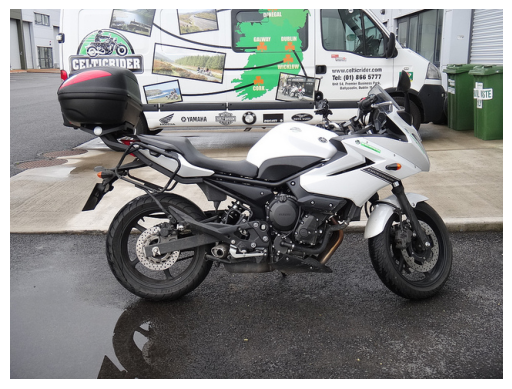

A motorcycle is parked near a puddle and a van.
A white and black motorcycle sits next to a van in a parking lot.
A white and black motorcycle sits in a parking spot. 
A white motorcycle sitting in front of a van.
A white motorcycle parked next to a sidewalk.


In [28]:
def read_image_coco(image_id, image_dir):
    image_path = os.path.join(image_dir, f'{image_id:012d}.jpg')
    image = plt.imread(image_path)
    return image

def show_random_image_info(annotations_file, images_dir):
    with open(annotations_file, 'r') as f:
        annotations = json.load(f)
        
    random_annotation = annotations['annotations'][np.random.randint(len(annotations['annotations']))]
    image_id = random_annotation['image_id']
    image = read_image_coco(image_id, images_dir)
    captions = [annotation['caption'] for annotation in annotations['annotations'] if annotation['image_id'] == image_id]
    formatted_id = f'{image_id:012d}'
    image_path = os.path.join(images_dir, formatted_id + '.jpg')

    print(f"Image ID: {formatted_id}")
    print(f"Number of captions: {len(captions)}")
    print(f"Image URL: {image_path}")

    plt.imshow(image)
    plt.axis('off')
    plt.show()
    
    for caption in captions:
        print(caption)
       
    
show_random_image_info(val_annotations, val_images_dir)

In [29]:
print(f"Number of training images: {len(os.listdir(train_images_dir))}")
print(f"Number of validation images: {len(os.listdir(val_images_dir))}")
print(f"Number of test images: {len(os.listdir(test_images_dir))}")

Number of training images: 118287
Number of validation images: 5000
Number of test images: 40670


In [30]:
def calculate_caption_count_stats(train_annotations):
    with open(train_annotations, 'r') as f:
        annotations = json.load(f)

    image_caption_counts = {annotation['image_id']: 0 for annotation in annotations['annotations']}
    caption_lengths = []
    for annotation in annotations['annotations']:
        image_caption_counts[annotation['image_id']] += 1
        caption_lengths.append(len(annotation['caption']))

    caption_counts = list(image_caption_counts.values())
    caption_count_stats = {
        'mean': np.mean(caption_counts),
        'median': np.median(caption_counts),
        'min': np.min(caption_counts),
        'max': np.max(caption_counts),
        'avg_caption_length': np.mean(caption_lengths)
    }

    for stat, value in caption_count_stats.items():
        print(f"\t- {stat}: {value}")
        
print("Caption count per image statistics in training set:")
calculate_caption_count_stats(train_annotations)

print("\nCaption count per image statistics in validation set:")
calculate_caption_count_stats(val_annotations)

Caption count per image statistics in training set:
	- mean: 5.002688376575617
	- median: 5.0
	- min: 5
	- max: 7
	- avg_caption_length: 52.4888678215404

Caption count per image statistics in validation set:
	- mean: 5.0028
	- median: 5.0
	- min: 5
	- max: 7
	- avg_caption_length: 52.42028464060127


In [31]:

class CustomCocoDataset(Dataset):
    def __init__(self, image_dir, annotations_file, transform=None):
        if not os.path.exists(annotations_file):
            raise ValueError(f"File annotations không tồn tại: {annotations_file}")

        with open(annotations_file, 'r') as f:
            self.annotations = json.load(f)

        self.image_dir = image_dir
        self.transform = transform if transform else ToTensor()

    def __len__(self):
        return len(self.annotations['annotations'])

    def __getitem__(self, idx):
        image_id = self.annotations['annotations'][idx]['image_id']
        image_path = os.path.join(self.image_dir, f'{image_id:012d}.jpg')
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        caption = self.annotations['annotations'][idx]['caption']
        caption = re.sub('[^A-Za-z0-9]+', ' ', caption)
        caption = caption.lower().strip()
        caption = caption.replace('.', '')
        return image, caption

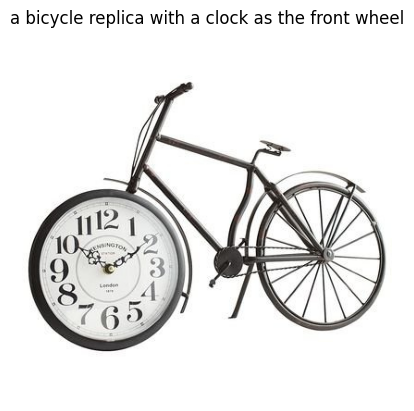

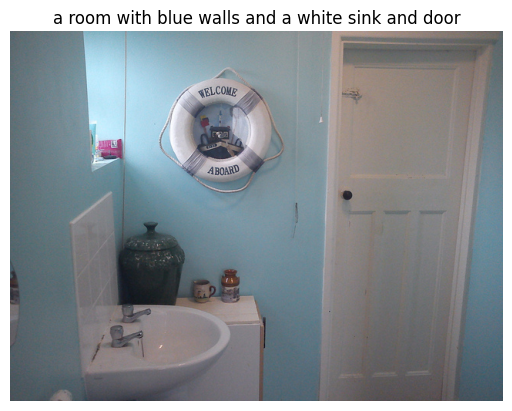

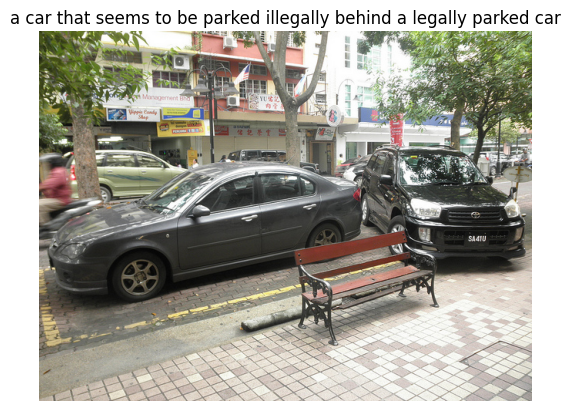

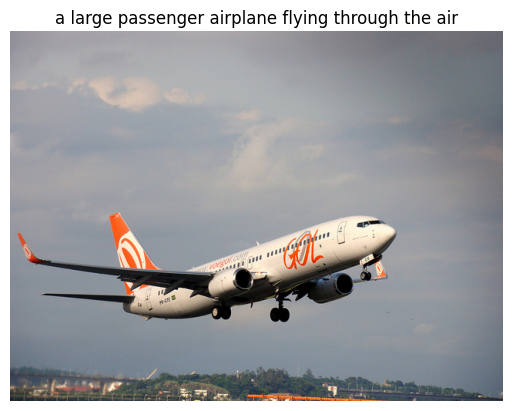

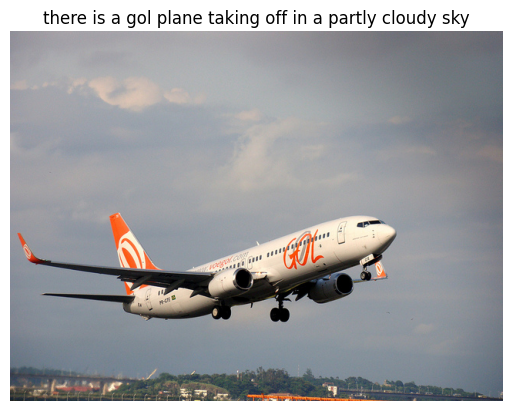

In [32]:
custom_coco_dataset = CustomCocoDataset(train_images_dir, train_annotations)

for i in range(5):
    image, caption = custom_coco_dataset[i]
    if image is None or caption is None:
        continue

    plt.imshow(image.permute(1, 2, 0))
    plt.title(caption)
    plt.axis('off')
    plt.show()    

In [33]:
def calculate_mean_std(dataset, device):
    mean_sum = torch.tensor([0.0, 0.0, 0.0], device=device)
    std_sum = torch.tensor([0.0, 0.0, 0.0], device=device)
    n_samples = 0

    for img_tensor, _ in tqdm(dataset, desc='Calculating mean and std'):
        img_tensor = img_tensor.to(device)
        mean_sum += img_tensor.mean([-1, -2])
        std_sum += img_tensor.std([-1, -2])
        n_samples += 1

    mean = mean_sum / n_samples
    std = std_sum / n_samples

    return mean.cpu(), std.cpu()

train_dataset = CustomCocoDataset(train_images_dir, train_annotations, transform=transforms.ToTensor())

In [35]:
from torch.utils.data import DataLoader
from torchvision import transforms

train_dataset = CustomCocoDataset(train_images_dir, train_annotations, transform=transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
#     transforms.Normalize(mean=[0.4700, 0.4468, 0.4076], std=[0.2439, 0.2390, 0.2420])
]))

val_dataset = CustomCocoDataset(val_images_dir, val_annotations, transform=transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
#     transforms.Normalize(mean=[0.4700, 0.4468, 0.4076], std=[0.2439, 0.2390, 0.2420])
]))

def collate_fn(batch):
    images, captions = zip(*batch)
    return torch.stack(images), captions  # Stack images, keep captions as list

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=12, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=12, collate_fn=collate_fn)

In [36]:
print(f"Number of training batches: {len(train_dataloader)}")
print(f"Number of validation batches: {len(val_dataloader)}")
print("\n")
print(f"Number of training images: {len(train_dataset)}")
print(f"Number of validation images: {len(val_dataset)}")

Number of training batches: 36985
Number of validation batches: 1564


Number of training images: 591753
Number of validation images: 25014


In [37]:
images, captions = next(iter(train_dataloader))
print(f"Shape of images in a batch: {images.shape}")

Shape of images in a batch: torch.Size([16, 3, 256, 256])


In [38]:
def get_subset_dataloader(dataloader, subset_percent):
    num_samples = int(len(dataloader.dataset) * subset_percent)
    subset = Subset(dataloader.dataset, range(num_samples))
    subset_dataloader = DataLoader(subset, batch_size=dataloader.batch_size, collate_fn=dataloader.collate_fn)
    return subset_dataloader

# Get 10% of the original train and val DataLoaders
train_dataloader = get_subset_dataloader(train_dataloader, 0.01) # 1%
val_dataloader = get_subset_dataloader(val_dataloader, 0.01)

# Print the number of batches in the original and subset DataLoaders
print(f"Number of batches in the 10% subset train DataLoader: {len(train_dataloader)}")
print(f"Number of batches in the 10% subset val DataLoader: {len(val_dataloader)}")

Number of batches in the 10% subset train DataLoader: 370
Number of batches in the 10% subset val DataLoader: 16


In [39]:
print(f"Number of training images in 10% subset: {len(train_dataloader) * train_dataloader.batch_size}")
print(f"Number of validation images in 10% subset: {len(val_dataloader) * val_dataloader.batch_size}")

Number of training images in 10% subset: 5920
Number of validation images in 10% subset: 256


In [40]:
from sentence_transformers import SentenceTransformer
sbert_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
text_emb_size = 384
img_size = 256

In [41]:
def encode_captions(captions):
    encoded_captions = sbert_model.encode(captions, show_progress_bar=False)
    return torch.tensor(encoded_captions, dtype=torch.float32)

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        if hasattr(m, 'weight') and m.weight is not None:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        if hasattr(m, 'weight') and m.weight is not None:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
        if hasattr(m, 'bias') and m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    elif classname.find('ConvTranspose') != -1:
        if hasattr(m, 'weight') and m.weight is not None:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('Linear') != -1:
        if hasattr(m, 'weight') and m.weight is not None:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        if hasattr(m, 'bias') and m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
            
# SpectralNorm implementation
def l2normalize(v, eps=1e-12):
    return v / (v.norm() + eps)

class SpectralNorm(nn.Module):
    def __init__(self, module, name='weight', power_iterations=1):
        super(SpectralNorm, self).__init__()
        self.module = module
        self.name = name
        self.power_iterations = power_iterations
        if not self._made_params():
            self._make_params()

    def _update_u_v(self):
        u = getattr(self.module, self.name + "_u")
        v = getattr(self.module, self.name + "_v")
        w = getattr(self.module, self.name + "_bar")

        height = w.data.shape[0]
        for _ in range(self.power_iterations):
            v.data = l2normalize(torch.mv(torch.t(w.view(height,-1).data), u.data))
            u.data = l2normalize(torch.mv(w.view(height,-1).data, v.data))

        sigma = u.dot(w.view(height, -1).mv(v))
        setattr(self.module, self.name, w / sigma.expand_as(w))

    def _made_params(self):
        try:
            u = getattr(self.module, self.name + "_u")
            v = getattr(self.module, self.name + "_v")
            w = getattr(self.module, self.name + "_bar")
            return True
        except AttributeError:
            return False

    def _make_params(self):
        w = getattr(self.module, self.name)

        height = w.data.shape[0]
        width = w.view(height, -1).data.shape[1]

        u = nn.Parameter(w.data.new(height).normal_(0, 1), requires_grad=False)
        v = nn.Parameter(w.data.new(width).normal_(0, 1), requires_grad=False)
        u.data = l2normalize(u.data)
        v.data = l2normalize(v.data)
        w_bar = nn.Parameter(w.data)

        del self.module._parameters[self.name]

        self.module.register_parameter(self.name + "_u", u)
        self.module.register_parameter(self.name + "_v", v)
        self.module.register_parameter(self.name + "_bar", w_bar)

    def forward(self, *args):
        self._update_u_v()
        return self.module.forward(*args)

In [43]:
class Generator(nn.Module):
    def __init__(self, text_emb_size, img_size):
        super(Generator, self).__init__()
        self.fc = nn.Linear(text_emb_size, 512 * img_size // 16 * img_size // 16)
        self.main = nn.Sequential(
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, text_emb):
        x = self.fc(text_emb)
        x = x.view(-1, 512, img_size // 16, img_size // 16)
        return self.main(x)

# Discriminator model
class Discriminator(nn.Module):
    def __init__(self, img_size, text_emb_size):
        super(Discriminator, self).__init__()
        self.img_branch = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            SpectralNorm(nn.Conv2d(64, 128, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            SpectralNorm(nn.Conv2d(128, 256, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True)
            
        )
        self.text_branch = nn.Sequential(
            nn.Linear(text_emb_size, 256),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.joint_conv = nn.Sequential(
            SpectralNorm(nn.Conv2d(512, 512, 1, 1, 0, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            SpectralNorm(nn.Conv2d(512, 1, 4, 1, 0, bias=False)),
            nn.Sigmoid()
        )

    def forward(self, img, text_emb):
        img_feat = self.img_branch(img)
        text_feat = self.text_branch(text_emb)
        text_feat = text_feat.unsqueeze(2).unsqueeze(3)
        text_feat = text_feat.expand(-1, -1, img_feat.size(2), img_feat.size(3))
        joint_feat = torch.cat([img_feat, text_feat], dim=1)
        output = self.joint_conv(joint_feat).view(-1)
        return output

# GAN model
class GAN(nn.Module):
    def __init__(self, text_emb_size, img_size):
        super(GAN, self).__init__()
        self.generator = Generator(text_emb_size, img_size)
        self.discriminator = Discriminator(img_size, text_emb_size)

        self.generator.apply(weights_init)
        self.discriminator.apply(weights_init)

    def forward(self, text_emb, img_size):
        fake_images = self.generator(text_emb, img_size)
        return fake_images
    
gan = GAN(text_emb_size, img_size).to(device)

print(gan)

GAN(
  (generator): Generator(
    (fc): Linear(in_features=384, out_features=131072, bias=True)
    (main): Sequential(
      (0): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): ReLU(inplace=True)
      (2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): ReLU(inplace=True)
      (5): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): ReLU(inplace=True)
      (8): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU(inplace=True)
      (11): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=F

In [44]:
lr_gen = 0.0002
lr_disc = 0.0002

# Khởi tạo optimizers
optim_gen = torch.optim.Adam(gan.generator.parameters(), lr=lr_gen, betas=(0.5, 0.999))
optim_disc = torch.optim.Adam(gan.discriminator.parameters(), lr=lr_disc, betas=(0.5, 0.999))

# Hàm mất mát
criterion = nn.BCELoss()

# Số lượng epochs huấn luyện
num_epochs = 50

# Lưu trữ lịch sử loss cho việc plot
gen_train_losses = []
disc_train_losses = []
gen_val_losses = []
disc_val_losses = []

# Khởi tạo learning rates hiện tại
optim_gen_lr = lr_gen
optim_disc_lr = lr_disc

# Lưu trữ số lượng epochs mà loss không giảm
num_epochs_no_improve_gen = 0
num_epochs_no_improve_disc = 0

# Khởi tạo loss tốt nhất trên tập kiểm tra
best_gen_val_loss = float('inf')
best_disc_val_loss = float('inf')
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Khởi tạo schedulers
scheduler_gen = ReduceLROnPlateau(optim_gen, mode='min', factor=0.5, patience=10, verbose=True)
scheduler_disc = ReduceLROnPlateau(optim_disc, mode='min', factor=0.5, patience=10, verbose=True)

In [45]:
import numpy as np
import torch
from PIL import Image
from scipy import linalg
from torch import nn
import torch.nn.functional as F
from torchvision.models import inception_v3
import cv2
import multiprocessing
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.inception import InceptionScore
from tqdm import tqdm

# Ensure `to_cuda` and `encode_captions` are defined as used in your original code.

# Initialize FID and IS metrics
fid_metric = FrechetInceptionDistance(feature=2048).to(device)
is_metric = InceptionScore().to(device)

for epoch in range(num_epochs):
    # Training loop
    gen_train_loss = 0.0
    disc_train_loss = 0.0
    for batch_idx, (images, captions) in enumerate(tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{num_epochs}')):
        real_images = images.to(device)
        text_embeddings = encode_captions(captions).to(device) # using SBERT for caption embedding

        # ===== Train Discriminator =====
        optim_disc.zero_grad()

        with torch.no_grad():
            fake_images = gan.generator(text_embeddings)

        real_preds = gan.discriminator(real_images, text_embeddings)
        fake_preds = gan.discriminator(fake_images.detach(), text_embeddings)

        disc_real_loss = criterion(real_preds, torch.ones_like(real_preds))
        disc_fake_loss = criterion(fake_preds, torch.zeros_like(fake_preds))
        disc_loss = disc_real_loss + disc_fake_loss
        disc_train_loss += disc_loss.item()

        disc_loss.backward()
        optim_disc.step()

        # ===== Train Generator =====
        optim_gen.zero_grad()

        fake_images = gan.generator(text_embeddings)
        fake_preds = gan.discriminator(fake_images, text_embeddings)
        gen_loss = criterion(fake_preds, torch.ones_like(fake_preds))
        gen_train_loss += gen_loss.item()

        gen_loss.backward()
        optim_gen.step()

    # Calculate average training losses
    gen_train_loss /= len(train_dataloader)
    disc_train_loss /= len(train_dataloader)

    # Evaluation loop
    gen_val_loss = 0.0
    disc_val_loss = 0.0
    with torch.no_grad():
        for val_batch_idx, (val_images, val_captions) in enumerate(tqdm(val_dataloader, desc='Validation')):
            val_real_images = val_images.to(device)
            val_text_embeddings = encode_captions(val_captions).to(device)

            # Evaluate Discriminator
            val_fake_images = gan.generator(val_text_embeddings)
            val_real_preds = gan.discriminator(val_real_images, val_text_embeddings)
            val_fake_preds = gan.discriminator(val_fake_images.detach(), val_text_embeddings)

            val_disc_real_loss = criterion(val_real_preds, torch.ones_like(val_real_preds))
            val_disc_fake_loss = criterion(val_fake_preds, torch.zeros_like(val_fake_preds))
            val_disc_loss = val_disc_real_loss + val_disc_fake_loss
            disc_val_loss += val_disc_loss.item()

            # Evaluate Generator
            val_fake_preds = gan.discriminator(val_fake_images, val_text_embeddings)
            val_gen_loss = criterion(val_fake_preds, torch.ones_like(val_fake_preds))
            gen_val_loss += val_gen_loss.item()

    # Calculate average validation losses
    disc_val_loss /= len(val_dataloader)
    gen_val_loss /= len(val_dataloader)

    # Save losses
    gen_train_losses.append(gen_train_loss)
    disc_train_losses.append(disc_train_loss)
    gen_val_losses.append(gen_val_loss)
    disc_val_losses.append(disc_val_loss)

    # Calculate FID and IS score
    real_images_for_fid = []
    fake_images_for_fid = []

    # Collect real and fake images for FID calculation
    for val_batch_idx, (val_images, val_captions) in enumerate(val_dataloader):
        val_real_images = val_images.to(device)
        val_text_embeddings = encode_captions(val_captions).to(device)
        val_fake_images = gan.generator(val_text_embeddings)

        real_images_for_fid.append(val_real_images)
        fake_images_for_fid.append(val_fake_images)

    # Combine the list of tensors into a single tensor
    real_images_for_fid = torch.cat(real_images_for_fid, dim=0)
    fake_images_for_fid = torch.cat(fake_images_for_fid, dim=0)

    # Compute FID
    real_images_for_fid = torch.clamp(real_images_for_fid, 0, 1)
    fake_images_for_fid = torch.clamp(fake_images_for_fid, 0, 1)
    real_images_for_fid = (real_images_for_fid * 255).to(torch.uint8)
    fake_images_for_fid = (fake_images_for_fid * 255).to(torch.uint8)
    fid_metric.update(real_images_for_fid, real=True)
    fid_metric.update(fake_images_for_fid, real=False)
    fid_score = fid_metric.compute()
    fid_metric.reset()

    # Compute IS
    is_metric.update(fake_images_for_fid)
    is_score, is_std = is_metric.compute()
    is_metric.reset()

    print(f'FID score: {fid_score:.4f}')
    print(f'Inception Score: {is_score:.4f} ± {is_std:.4f}')

    # Print training and validation losses
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Discriminator Loss: {disc_train_loss:.4f}, Training Generator Loss: {gen_train_loss:.4f}')
    print(f'Epoch [{epoch+1}/{num_epochs}], Validation Discriminator Loss: {disc_val_loss:.4f}, Validation Generator Loss: {gen_val_loss:.4f}')
    
    # Log to wandb (Optional)
    # wandb.log({"gen_train_loss": gen_train_loss, 
    #        "disc_train_loss": disc_train_loss,
    #        "gen_val_loss": gen_val_loss,
    #        "disc_val_loss": disc_val_loss,
    #        "gen_lr": optim_gen_lr,
    #        "disc_lr": optim_disc_lr,
    #        "fid_score": fid_score,
    #        "inception_score": is_score})

    # Update learning rate schedulers
    scheduler_gen.step(gen_val_loss)
    scheduler_disc.step(disc_val_loss)

    # Update learning rate schedulers
#     if gen_val_loss < best_gen_val_loss:
#         best_gen_val_loss = gen_val_loss
#         num_epochs_no_improve_gen = 0
#     else:
#         num_epochs_no_improve_gen += 1

#     if disc_val_loss < best_disc_val_loss:
#         best_disc_val_loss = disc_val_loss
#         num_epochs_no_improve_disc = 0
#     else:
#         num_epochs_no_improve_disc += 1

#     if num_epochs_no_improve_gen >= 10:  # Giảm learning rate nếu loss không giảm trong 10 epochs
#         optim_gen_lr *= 0.5
#         num_epochs_no_improve_gen = 0
#         optim_gen = torch.optim.Adam(gan.generator.parameters(), lr=optim_gen_lr, betas=(0.5, 0.999))

#     if num_epochs_no_improve_disc >= 10:
#         optim_disc_lr *= 0.5
#         num_epochs_no_improve_disc = 0
#         optim_disc = torch.optim.Adam(gan.discriminator.parameters(), lr=optim_disc_lr, betas=(0.5, 0.999))

# Save the final model
torch.save(gan.state_dict(), 'GAN_txt2img_model.pth')
wandb.finish()

Validation: 100%|██████████| 16/16 [00:02<00:00,  6.15it/s]


FID score: 349.1502
Inception Score: 1.3005 ± 0.0455
Epoch [1/50], Training Discriminator Loss: 1.3744, Training Generator Loss: 0.7210
Epoch [1/50], Validation Discriminator Loss: 1.4266, Validation Generator Loss: 0.7070


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.23it/s]


FID score: 350.5145
Inception Score: 1.4873 ± 0.0607
Epoch [2/50], Training Discriminator Loss: 1.3835, Training Generator Loss: 0.7088
Epoch [2/50], Validation Discriminator Loss: 1.3825, Validation Generator Loss: 0.7069


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.44it/s]


FID score: 375.4441
Inception Score: 1.4053 ± 0.0628
Epoch [3/50], Training Discriminator Loss: 1.3831, Training Generator Loss: 0.7019
Epoch [3/50], Validation Discriminator Loss: 1.3796, Validation Generator Loss: 0.7072


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.39it/s]


FID score: 344.3362
Inception Score: 1.2251 ± 0.0437
Epoch [4/50], Training Discriminator Loss: 1.3797, Training Generator Loss: 0.7167
Epoch [4/50], Validation Discriminator Loss: 1.3652, Validation Generator Loss: 0.6676


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.60it/s]


FID score: 370.3458
Inception Score: 1.6526 ± 0.0875
Epoch [5/50], Training Discriminator Loss: 1.3812, Training Generator Loss: 0.7110
Epoch [5/50], Validation Discriminator Loss: 1.3686, Validation Generator Loss: 0.6967


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.40it/s]


FID score: 367.3658
Inception Score: 1.9407 ± 0.0814
Epoch [6/50], Training Discriminator Loss: 1.3821, Training Generator Loss: 0.7090
Epoch [6/50], Validation Discriminator Loss: 1.3443, Validation Generator Loss: 0.6357


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.54it/s]


FID score: 316.9166
Inception Score: 1.1734 ± 0.0228
Epoch [7/50], Training Discriminator Loss: 1.3826, Training Generator Loss: 0.7060
Epoch [7/50], Validation Discriminator Loss: 1.3764, Validation Generator Loss: 0.7145


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.47it/s]


FID score: 311.1487
Inception Score: 1.2919 ± 0.0326
Epoch [8/50], Training Discriminator Loss: 1.3855, Training Generator Loss: 0.6997
Epoch [8/50], Validation Discriminator Loss: 1.3792, Validation Generator Loss: 0.6853


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.55it/s]


FID score: 324.1230
Inception Score: 1.2117 ± 0.0447
Epoch [9/50], Training Discriminator Loss: 1.3854, Training Generator Loss: 0.7001
Epoch [9/50], Validation Discriminator Loss: 1.3918, Validation Generator Loss: 0.6951


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.57it/s]


FID score: 366.6382
Inception Score: 1.4767 ± 0.0827
Epoch [10/50], Training Discriminator Loss: 1.3837, Training Generator Loss: 0.7047
Epoch [10/50], Validation Discriminator Loss: 1.3788, Validation Generator Loss: 0.6790


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.46it/s]


FID score: 320.3430
Inception Score: 1.5772 ± 0.0812
Epoch [11/50], Training Discriminator Loss: 1.3835, Training Generator Loss: 0.7041
Epoch [11/50], Validation Discriminator Loss: 1.3618, Validation Generator Loss: 0.7819


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.45it/s]


FID score: 345.5327
Inception Score: 1.6478 ± 0.0649
Epoch [12/50], Training Discriminator Loss: 1.3832, Training Generator Loss: 0.7035
Epoch [12/50], Validation Discriminator Loss: 1.3906, Validation Generator Loss: 0.7202


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.62it/s]


FID score: 399.6288
Inception Score: 1.3087 ± 0.0656
Epoch [13/50], Training Discriminator Loss: 1.3826, Training Generator Loss: 0.7079
Epoch [13/50], Validation Discriminator Loss: 1.3764, Validation Generator Loss: 0.6992


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.44it/s]


FID score: 371.5366
Inception Score: 1.6869 ± 0.1114
Epoch [14/50], Training Discriminator Loss: 1.3793, Training Generator Loss: 0.7113
Epoch [14/50], Validation Discriminator Loss: 1.3914, Validation Generator Loss: 0.7206


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.53it/s]


FID score: 326.9239
Inception Score: 1.2840 ± 0.0515
Epoch [15/50], Training Discriminator Loss: 1.3818, Training Generator Loss: 0.7057
Epoch [15/50], Validation Discriminator Loss: 1.3810, Validation Generator Loss: 0.7002


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.40it/s]


FID score: 384.0067
Inception Score: 1.2308 ± 0.0482
Epoch [16/50], Training Discriminator Loss: 1.3814, Training Generator Loss: 0.7089
Epoch [16/50], Validation Discriminator Loss: 1.3692, Validation Generator Loss: 0.5962


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.34it/s]


FID score: 346.9091
Inception Score: 1.3557 ± 0.0521
Epoch [17/50], Training Discriminator Loss: 1.3812, Training Generator Loss: 0.7128
Epoch [17/50], Validation Discriminator Loss: 1.3627, Validation Generator Loss: 0.6916
Epoch 00017: reducing learning rate of group 0 to 1.0000e-04.


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.54it/s]


FID score: 330.6282
Inception Score: 1.3556 ± 0.0490
Epoch [18/50], Training Discriminator Loss: 1.3845, Training Generator Loss: 0.6976
Epoch [18/50], Validation Discriminator Loss: 1.3904, Validation Generator Loss: 0.6911


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.41it/s]


FID score: 325.5230
Inception Score: 1.1210 ± 0.0364
Epoch [19/50], Training Discriminator Loss: 1.3854, Training Generator Loss: 0.6967
Epoch [19/50], Validation Discriminator Loss: 1.3692, Validation Generator Loss: 0.6839


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.53it/s]


FID score: 339.4430
Inception Score: 1.1117 ± 0.0193
Epoch [20/50], Training Discriminator Loss: 1.3858, Training Generator Loss: 0.6965
Epoch [20/50], Validation Discriminator Loss: 1.3902, Validation Generator Loss: 0.6804


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.62it/s]


FID score: 339.0194
Inception Score: 1.1125 ± 0.0161
Epoch [21/50], Training Discriminator Loss: 1.3856, Training Generator Loss: 0.6954
Epoch [21/50], Validation Discriminator Loss: 1.3864, Validation Generator Loss: 0.6951


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.43it/s]


FID score: 347.8798
Inception Score: 1.1842 ± 0.0466
Epoch [22/50], Training Discriminator Loss: 1.3860, Training Generator Loss: 0.6968
Epoch [22/50], Validation Discriminator Loss: 1.3840, Validation Generator Loss: 0.7034


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.51it/s]


FID score: 389.7102
Inception Score: 1.1020 ± 0.0305
Epoch [23/50], Training Discriminator Loss: 1.3861, Training Generator Loss: 0.6940
Epoch [23/50], Validation Discriminator Loss: 1.3908, Validation Generator Loss: 0.7031


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.20it/s]


FID score: 362.6448
Inception Score: 1.2407 ± 0.0703
Epoch [24/50], Training Discriminator Loss: 1.3863, Training Generator Loss: 0.6946
Epoch [24/50], Validation Discriminator Loss: 1.3848, Validation Generator Loss: 0.6883


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.42it/s]


FID score: 366.6265
Inception Score: 1.0681 ± 0.0468
Epoch [25/50], Training Discriminator Loss: 1.3864, Training Generator Loss: 0.6945
Epoch [25/50], Validation Discriminator Loss: 1.3874, Validation Generator Loss: 0.6857


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.32it/s]


FID score: 326.2293
Inception Score: 1.1063 ± 0.0362
Epoch [26/50], Training Discriminator Loss: 1.3863, Training Generator Loss: 0.6945
Epoch [26/50], Validation Discriminator Loss: 1.3888, Validation Generator Loss: 0.7027


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.65it/s]


FID score: 343.4607
Inception Score: 1.1902 ± 0.0609
Epoch [27/50], Training Discriminator Loss: 1.3861, Training Generator Loss: 0.6940
Epoch [27/50], Validation Discriminator Loss: 1.3863, Validation Generator Loss: 0.7032
Epoch 00027: reducing learning rate of group 0 to 1.0000e-04.


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.17it/s]


FID score: 372.9870
Inception Score: 1.0947 ± 0.0228
Epoch [28/50], Training Discriminator Loss: 1.3859, Training Generator Loss: 0.6937
Epoch [28/50], Validation Discriminator Loss: 1.3879, Validation Generator Loss: 0.6917
Epoch 00028: reducing learning rate of group 0 to 5.0000e-05.


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.21it/s]


FID score: 348.4337
Inception Score: 1.1887 ± 0.0551
Epoch [29/50], Training Discriminator Loss: 1.3857, Training Generator Loss: 0.6940
Epoch [29/50], Validation Discriminator Loss: 1.3867, Validation Generator Loss: 0.6904


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.00it/s]


FID score: 365.8350
Inception Score: 1.1490 ± 0.0720
Epoch [30/50], Training Discriminator Loss: 1.3857, Training Generator Loss: 0.6938
Epoch [30/50], Validation Discriminator Loss: 1.3881, Validation Generator Loss: 0.6892


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.48it/s]


FID score: 362.9430
Inception Score: 1.1568 ± 0.0654
Epoch [31/50], Training Discriminator Loss: 1.3857, Training Generator Loss: 0.6938
Epoch [31/50], Validation Discriminator Loss: 1.3870, Validation Generator Loss: 0.6941


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.45it/s]


FID score: 359.8000
Inception Score: 1.0620 ± 0.0174
Epoch [32/50], Training Discriminator Loss: 1.3858, Training Generator Loss: 0.6939
Epoch [32/50], Validation Discriminator Loss: 1.3876, Validation Generator Loss: 0.6912


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.41it/s]


FID score: 368.5011
Inception Score: 1.0616 ± 0.0273
Epoch [33/50], Training Discriminator Loss: 1.3859, Training Generator Loss: 0.6938
Epoch [33/50], Validation Discriminator Loss: 1.3874, Validation Generator Loss: 0.6861


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.46it/s]


FID score: 346.3835
Inception Score: 1.1040 ± 0.0240
Epoch [34/50], Training Discriminator Loss: 1.3859, Training Generator Loss: 0.6942
Epoch [34/50], Validation Discriminator Loss: 1.3864, Validation Generator Loss: 0.6874


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.37it/s]


FID score: 394.8564
Inception Score: 1.0405 ± 0.0219
Epoch [35/50], Training Discriminator Loss: 1.3858, Training Generator Loss: 0.6938
Epoch [35/50], Validation Discriminator Loss: 1.3879, Validation Generator Loss: 0.6861


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.47it/s]


FID score: 371.5300
Inception Score: 1.0614 ± 0.0132
Epoch [36/50], Training Discriminator Loss: 1.3858, Training Generator Loss: 0.6939
Epoch [36/50], Validation Discriminator Loss: 1.3873, Validation Generator Loss: 0.6922


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.13it/s]


FID score: 363.4165
Inception Score: 1.1403 ± 0.0345
Epoch [37/50], Training Discriminator Loss: 1.3858, Training Generator Loss: 0.6939
Epoch [37/50], Validation Discriminator Loss: 1.3885, Validation Generator Loss: 0.6881


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.57it/s]


FID score: 376.1773
Inception Score: 1.0695 ± 0.0235
Epoch [38/50], Training Discriminator Loss: 1.3859, Training Generator Loss: 0.6944
Epoch [38/50], Validation Discriminator Loss: 1.3867, Validation Generator Loss: 0.6808
Epoch 00038: reducing learning rate of group 0 to 5.0000e-05.


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.60it/s]


FID score: 383.5497
Inception Score: 1.0424 ± 0.0278
Epoch [39/50], Training Discriminator Loss: 1.3856, Training Generator Loss: 0.6943
Epoch [39/50], Validation Discriminator Loss: 1.3889, Validation Generator Loss: 0.6912
Epoch 00039: reducing learning rate of group 0 to 2.5000e-05.


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.43it/s]


FID score: 369.6798
Inception Score: 1.0748 ± 0.0320
Epoch [40/50], Training Discriminator Loss: 1.3857, Training Generator Loss: 0.6940
Epoch [40/50], Validation Discriminator Loss: 1.3876, Validation Generator Loss: 0.6944


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.69it/s]


FID score: 324.3173
Inception Score: 1.2083 ± 0.0576
Epoch [41/50], Training Discriminator Loss: 1.3855, Training Generator Loss: 0.6938
Epoch [41/50], Validation Discriminator Loss: 1.3871, Validation Generator Loss: 0.6943


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.49it/s]


FID score: 335.6759
Inception Score: 1.1692 ± 0.0444
Epoch [42/50], Training Discriminator Loss: 1.3854, Training Generator Loss: 0.6938
Epoch [42/50], Validation Discriminator Loss: 1.3873, Validation Generator Loss: 0.6939


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.49it/s]


FID score: 310.0102
Inception Score: 1.3790 ± 0.0509
Epoch [43/50], Training Discriminator Loss: 1.3855, Training Generator Loss: 0.6938
Epoch [43/50], Validation Discriminator Loss: 1.3867, Validation Generator Loss: 0.6935


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.46it/s]


FID score: 302.7004
Inception Score: 1.3399 ± 0.0386
Epoch [44/50], Training Discriminator Loss: 1.3855, Training Generator Loss: 0.6939
Epoch [44/50], Validation Discriminator Loss: 1.3866, Validation Generator Loss: 0.6950


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.47it/s]


FID score: 296.9207
Inception Score: 1.3400 ± 0.0641
Epoch [45/50], Training Discriminator Loss: 1.3854, Training Generator Loss: 0.6938
Epoch [45/50], Validation Discriminator Loss: 1.3877, Validation Generator Loss: 0.6918


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.63it/s]


FID score: 324.9198
Inception Score: 1.2300 ± 0.0285
Epoch [46/50], Training Discriminator Loss: 1.3855, Training Generator Loss: 0.6940
Epoch [46/50], Validation Discriminator Loss: 1.3874, Validation Generator Loss: 0.6925


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.31it/s]


FID score: 319.9959
Inception Score: 1.3001 ± 0.0661
Epoch [47/50], Training Discriminator Loss: 1.3855, Training Generator Loss: 0.6939
Epoch [47/50], Validation Discriminator Loss: 1.3873, Validation Generator Loss: 0.6959


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.39it/s]


FID score: 311.6734
Inception Score: 1.2795 ± 0.1090
Epoch [48/50], Training Discriminator Loss: 1.3855, Training Generator Loss: 0.6939
Epoch [48/50], Validation Discriminator Loss: 1.3871, Validation Generator Loss: 0.6981


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.65it/s]


FID score: 305.9966
Inception Score: 1.4430 ± 0.0704
Epoch [49/50], Training Discriminator Loss: 1.3855, Training Generator Loss: 0.6939
Epoch [49/50], Validation Discriminator Loss: 1.3872, Validation Generator Loss: 0.6970
Epoch 00049: reducing learning rate of group 0 to 2.5000e-05.


Validation: 100%|██████████| 16/16 [00:02<00:00,  6.23it/s]


FID score: 300.3406
Inception Score: 1.4650 ± 0.0522
Epoch [50/50], Training Discriminator Loss: 1.3852, Training Generator Loss: 0.6941
Epoch [50/50], Validation Discriminator Loss: 1.3865, Validation Generator Loss: 0.6931
Epoch 00050: reducing learning rate of group 0 to 1.2500e-05.


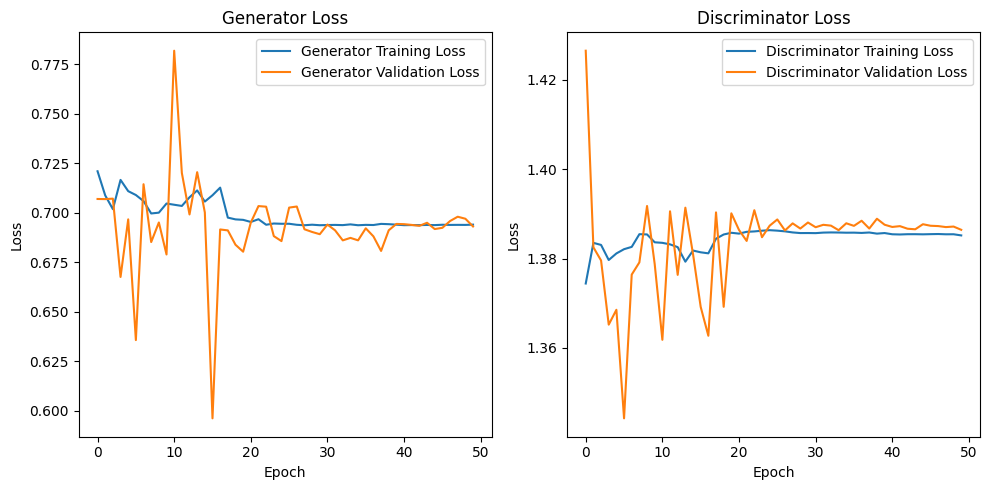

In [46]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(gen_train_losses, label='Generator Training Loss')
plt.plot(gen_val_losses, label='Generator Validation Loss')
plt.title('Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(disc_train_losses, label='Discriminator Training Loss')
plt.plot(disc_val_losses, label='Discriminator Validation Loss')
plt.title('Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

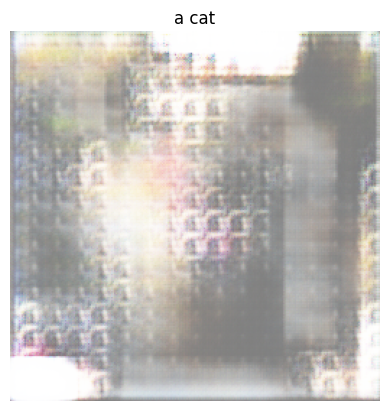

In [55]:
import torch
from torchvision.utils import save_image

# Khởi tạo mô hình GAN và load trọng số
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# gan = GAN(text_emb_size=384, img_size=224).to(device)
# gan.load_state_dict(torch.load('final_model.pth'))
gan.eval()  

sbert_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

def generate_image(caption):
    caption = re.sub('[^A-Za-z0-9]+', ' ', caption)
    caption = caption.lower().strip()
    caption = caption.replace('.', '')
    text_embedding = encode_captions([caption]).to(device)
    with torch.no_grad():
        generated_image = gan.generator(text_embedding)
        generated_image = (generated_image + 1) / 2  # Đưa giá trị về khoảng [0, 1]
    return generated_image

# Sinh ảnh từ caption
caption = "a cat"
generated_image = generate_image(caption)

plt.imshow(generated_image[0].cpu().permute(1, 2, 0))
plt.title(caption)
plt.axis('off')
plt.show()

# Lưu ảnh sinh ra
save_image(generated_image.cpu().data, '/kaggle/working/generated_image.png')

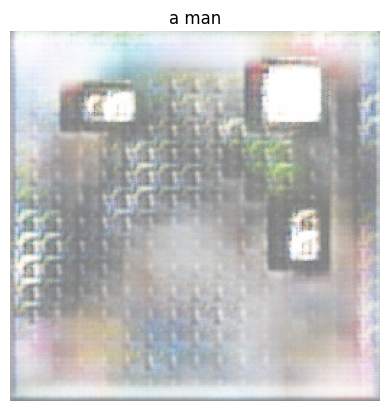

In [56]:
import torch
from torchvision.utils import save_image

# Khởi tạo mô hình GAN và load trọng số
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# gan = GAN(text_emb_size=384, img_size=224).to(device)
# gan.load_state_dict(torch.load('final_model.pth'))
gan.eval()  

sbert_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

def generate_image(caption):
    caption = re.sub('[^A-Za-z0-9]+', ' ', caption)
    caption = caption.lower().strip()
    caption = caption.replace('.', '')
    text_embedding = encode_captions([caption]).to(device)
    with torch.no_grad():
        generated_image = gan.generator(text_embedding)
        generated_image = (generated_image + 1) / 2  # Đưa giá trị về khoảng [0, 1]
    return generated_image

# Sinh ảnh từ caption
caption = "a man"
generated_image = generate_image(caption)

plt.imshow(generated_image[0].cpu().permute(1, 2, 0))
plt.title(caption)
plt.axis('off')
plt.show()

# Lưu ảnh sinh ra
save_image(generated_image.cpu().data, '/kaggle/working/generated_image.png')